In this notebook, we are looking for gaps in the proximity data collected by two badges - one with an old firmware, and one with the new firmware (2.0)

New badge (firmware 2.0) - C7:75:13:05:10:EE

Old badge - F9:4A:86:6E:F4:0C

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys
import datetime
import pandas as pd
import numpy as np
import pytz
import dateutil
import gzip

from ggplot import *
%matplotlib inline

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir)
sys.path.append(src_dir)

# import data analysis modules
import openbadge_analysis as ob

In [2]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# list of modules to autoload
%aimport openbadge_analysis

In [3]:
# config
filename = '/home/orenled/temp/logs/log_proximity.txt.gz'
log_filename = '/home/orenled/temp/logs/server.log.gz'

eastern = pytz.timezone('US/Eastern')
utc  = pytz.timezone('UTC')

# Find badge first reset

If we want to get a real sense of how many gaps we have, we need to discard data after the the badges stared to reset. We need to look at the actualy logfile to find that time. This isn't pretty, but it works.

In [4]:
with gzip.open(log_filename, 'r') as f:
    unsync_raw = [ line for line in f if 'unsync' in line]

In [5]:
import re
# use regex to get date and badge
unsync_split = [ re.match('(.*) - INFO - \[(.*)\]',line).group(1,2) for line in unsync_raw]

In [6]:
# load into a dataframe and convert the date
df_log = pd.DataFrame(unsync_split,columns=['datetime','badge_address'])
print(df_log.head())
print(df_log['datetime'].head())

                  datetime      badge_address
0  2017-01-10 16:03:36,444  C7:75:13:05:10:EE
1  2017-01-10 16:03:39,620  C7:59:BE:8B:9C:E0
2  2017-01-10 16:03:42,805  F2:37:E3:BA:70:9D
3  2017-01-10 16:03:46,686  D4:E4:47:A5:F0:B3
4  2017-01-10 16:03:49,766  D8:A1:84:25:FF:B7
0    2017-01-10 16:03:36,444
1    2017-01-10 16:03:39,620
2    2017-01-10 16:03:42,805
3    2017-01-10 16:03:46,686
4    2017-01-10 16:03:49,766
Name: datetime, dtype: object


In [7]:
df_log['datetime'] = pd.to_datetime(df_log['datetime'], utc=True)
df_log.sort_values('datetime')
df_log.index = pd.to_datetime(df_log.pop('datetime'), utc=True)

# this log is in EST
df_log = df_log.tz_localize(eastern)
print(df_log.head())
print(df_log.index.dtype)

                                      badge_address
datetime                                           
2017-01-10 16:03:36.444000-05:00  C7:75:13:05:10:EE
2017-01-10 16:03:39.620000-05:00  C7:59:BE:8B:9C:E0
2017-01-10 16:03:42.805000-05:00  F2:37:E3:BA:70:9D
2017-01-10 16:03:46.686000-05:00  D4:E4:47:A5:F0:B3
2017-01-10 16:03:49.766000-05:00  D8:A1:84:25:FF:B7
datetime64[ns, US/Eastern]


In [8]:
# reseting index, now that we converted the timezone (i'm not sure how to do this more efficiently...)
df_log = df_log.reset_index()
print(df_log.head())
print(df_log.datetime.dtype)

                          datetime      badge_address
0 2017-01-10 16:03:36.444000-05:00  C7:75:13:05:10:EE
1 2017-01-10 16:03:39.620000-05:00  C7:59:BE:8B:9C:E0
2 2017-01-10 16:03:42.805000-05:00  F2:37:E3:BA:70:9D
3 2017-01-10 16:03:46.686000-05:00  D4:E4:47:A5:F0:B3
4 2017-01-10 16:03:49.766000-05:00  D8:A1:84:25:FF:B7
datetime64[ns, US/Eastern]


The first reset (for every badge) is the first time we set the clock, so it's not really a reset

In [9]:
df_log_grp = df_log.groupby('badge_address')
start_time = df_log_grp.nth(0)
print("Start time\n",start_time,"\n\n")

first_reset = df_log_grp.nth(1)
print("First reset\n",first_reset,"\n\n")

# change to a more convinient format
first_reset = first_reset.reset_index()
first_reset.rename(columns={'datetime': 'first_reset_datetime'}, inplace=True)
first_reset['first_reset_timestamp'] = first_reset.pop('first_reset_datetime').astype(np.int64)//1e9
print("First reset, restructured\n", first_reset,"\n\n")

Start time
                                           datetime
badge_address                                     
C7:59:BE:8B:9C:E0 2017-01-10 16:03:39.620000-05:00
C7:75:13:05:10:EE 2017-01-10 16:03:36.444000-05:00
D4:E4:47:A5:F0:B3 2017-01-10 16:03:46.686000-05:00
D8:A1:84:25:FF:B7 2017-01-10 16:03:49.766000-05:00
F2:37:E3:BA:70:9D 2017-01-10 16:03:42.805000-05:00 


First reset
                                           datetime
badge_address                                     
C7:59:BE:8B:9C:E0 2017-01-17 08:43:16.419000-05:00
C7:75:13:05:10:EE 2017-01-16 00:06:19.142000-05:00
D4:E4:47:A5:F0:B3 2017-01-16 08:37:29.222000-05:00
D8:A1:84:25:FF:B7 2017-01-17 01:29:20.823000-05:00
F2:37:E3:BA:70:9D 2017-01-16 03:27:32.448000-05:00 


First reset, restructured
        badge_address  first_reset_timestamp
0  C7:59:BE:8B:9C:E0           1.484661e+09
1  C7:75:13:05:10:EE           1.484543e+09
2  D4:E4:47:A5:F0:B3           1.484574e+09
3  D8:A1:84:25:FF:B7           1.484635e+09
4  F2:37

# Look for gaps

In [10]:
with gzip.open(filename, 'r') as f:
    proximity_chunks = ob.load_proximity_chunks_as_json_objects(f, log_version='2.0')

In [11]:
# load data into a data frame
df = pd.DataFrame(proximity_chunks,columns=['badge_address','timestamp'])

# Converting timestamp (epoch) to UTC datetime
df['datetime'] = pd.to_datetime(df['timestamp'],unit='s', utc=True)

# Setting datetime as index
df.sort_values('datetime')
df.index = pd.to_datetime(df.pop('datetime'), utc=True)
df = df.tz_localize(utc)
df = df.tz_convert(eastern)
df = df.reset_index() # make it a column again

print(df.head(10))
print(df.dtypes)

                   datetime      badge_address     timestamp
0 2017-01-10 16:04:36-05:00  C7:75:13:05:10:EE  1.484082e+09
1 2017-01-10 16:04:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09
2 2017-01-10 16:04:42-05:00  F2:37:E3:BA:70:9D  1.484082e+09
3 2017-01-10 16:04:46-05:00  D4:E4:47:A5:F0:B3  1.484082e+09
4 2017-01-10 16:04:49-05:00  D8:A1:84:25:FF:B7  1.484082e+09
5 2017-01-10 16:05:36-05:00  C7:75:13:05:10:EE  1.484082e+09
6 2017-01-10 16:05:42-05:00  F2:37:E3:BA:70:9D  1.484082e+09
7 2017-01-10 16:05:46-05:00  D4:E4:47:A5:F0:B3  1.484082e+09
8 2017-01-10 16:05:49-05:00  D8:A1:84:25:FF:B7  1.484082e+09
9 2017-01-10 16:05:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09
datetime         datetime64[ns, US/Eastern]
badge_address                        object
timestamp                           float64
dtype: object


## Filter based on first reset time

In [12]:
if (len(first_reset)) > 0:
    df_fil = pd.merge(df,first_reset,how='left',on='badge_address')
    df_fil = df_fil[df_fil['timestamp'] < df_fil['first_reset_timestamp']]
    print("Records before filtering: {}, after: {}".format(len(df),len(df_fil)))

    #df_fil.index =  df_fil['datetime']
    del df_fil['first_reset_timestamp']
else:
    df_fil = df

Records before filtering: 42910, after: 42649


## Check for gaps in data

calculations are per-badge, so we must create a multi index. Then, per-group calculations can be done with group by

In [13]:
# http://pandas.pydata.org/pandas-docs/stable/advanced.html
# set multi-index
df_fil.set_index(['badge_address', 'datetime'], inplace=True, drop=False)

# sort is important for shift to work properly
df_fil.sort_index(inplace=True)
print(df_fil.head())

                                                             datetime  \
badge_address     datetime                                              
C7:59:BE:8B:9C:E0 2017-01-10 16:04:39-05:00 2017-01-10 16:04:39-05:00   
                  2017-01-10 16:05:39-05:00 2017-01-10 16:05:39-05:00   
                  2017-01-10 16:06:39-05:00 2017-01-10 16:06:39-05:00   
                  2017-01-10 16:07:39-05:00 2017-01-10 16:07:39-05:00   
                  2017-01-10 16:08:39-05:00 2017-01-10 16:08:39-05:00   

                                                 badge_address     timestamp  
badge_address     datetime                                                    
C7:59:BE:8B:9C:E0 2017-01-10 16:04:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09  
                  2017-01-10 16:05:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09  
                  2017-01-10 16:06:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09  
                  2017-01-10 16:07:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09  
              

In [14]:
# http://pandas.pydata.org/pandas-docs/stable/groupby.html
# group by badges, and shift ones so we can get the time of the previous row
grp_shift = df_fil.groupby(level=[0]).shift(1)
df_with_lag = df_fil.copy()
df_with_lag['timestamp_lag']= grp_shift['timestamp']
df_with_lag['time_diff']=df_with_lag['timestamp']-df_with_lag['timestamp_lag']
print("index dtype: ",df_with_lag.index.dtype)
print("Timediff type:", df_with_lag.time_diff.dtype)
print(df_with_lag.head())

index dtype:  object
Timediff type: float64
                                                             datetime  \
badge_address     datetime                                              
C7:59:BE:8B:9C:E0 2017-01-10 16:04:39-05:00 2017-01-10 16:04:39-05:00   
                  2017-01-10 16:05:39-05:00 2017-01-10 16:05:39-05:00   
                  2017-01-10 16:06:39-05:00 2017-01-10 16:06:39-05:00   
                  2017-01-10 16:07:39-05:00 2017-01-10 16:07:39-05:00   
                  2017-01-10 16:08:39-05:00 2017-01-10 16:08:39-05:00   

                                                 badge_address     timestamp  \
badge_address     datetime                                                     
C7:59:BE:8B:9C:E0 2017-01-10 16:04:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09   
                  2017-01-10 16:05:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09   
                  2017-01-10 16:06:39-05:00  C7:59:BE:8B:9C:E0  1.484082e+09   
                  2017-01-10 16:07:39-05:00 

Scans are performed every 60 seconds

In [15]:
seconds_between_chunks = 60
print("seconds between chunks: {}".format(seconds_between_chunks))

# time between chunks might vary slightly
seconds_between_chunks = seconds_between_chunks + 2
print("seconds between chunks: {}".format(seconds_between_chunks))

gaps = df_with_lag[df_with_lag['time_diff']>seconds_between_chunks]
print(gaps[['time_diff','timestamp']].head(70))

seconds between chunks: 60
seconds between chunks: 62
                                             time_diff     timestamp
badge_address     datetime                                          
C7:59:BE:8B:9C:E0 2017-01-17 02:00:59-05:00      120.0  1.484636e+09
                  2017-01-17 03:20:59-05:00     1020.0  1.484641e+09
                  2017-01-17 03:25:59-05:00      300.0  1.484642e+09
                  2017-01-17 03:28:59-05:00      180.0  1.484642e+09
                  2017-01-17 03:34:59-05:00      180.0  1.484642e+09
                  2017-01-17 03:39:59-05:00      240.0  1.484642e+09
                  2017-01-17 03:42:59-05:00      180.0  1.484643e+09
                  2017-01-17 03:45:59-05:00      120.0  1.484643e+09
                  2017-01-17 03:49:59-05:00      120.0  1.484643e+09
                  2017-01-17 03:52:59-05:00      120.0  1.484643e+09
                  2017-01-17 04:14:59-05:00     1320.0  1.484644e+09
                  2017-01-17 04:38:59-05:00     1

How many gaps are ther then? If you look below, you'll see that the number of gaps is very small. However, you need to remmeber that this include ALL data collected from the badges, even when they started to reset.

In [16]:
print(len(df))
print(len(gaps))
print(len(gaps)/len(df))

42910
25
0.000582614775111


In [17]:
gaps

datetime  \
badge_address     datetime                                              
C7:59:BE:8B:9C:E0 2017-01-17 02:00:59-05:00 2017-01-17 02:00:59-05:00   
                  2017-01-17 03:20:59-05:00 2017-01-17 03:20:59-05:00   
                  2017-01-17 03:25:59-05:00 2017-01-17 03:25:59-05:00   
                  2017-01-17 03:28:59-05:00 2017-01-17 03:28:59-05:00   
                  2017-01-17 03:34:59-05:00 2017-01-17 03:34:59-05:00   
                  2017-01-17 03:39:59-05:00 2017-01-17 03:39:59-05:00   
                  2017-01-17 03:42:59-05:00 2017-01-17 03:42:59-05:00   
                  2017-01-17 03:45:59-05:00 2017-01-17 03:45:59-05:00   
                  2017-01-17 03:49:59-05:00 2017-01-17 03:49:59-05:00   
                  2017-01-17 03:52:59-05:00 2017-01-17 03:52:59-05:00   
                  2017-01-17 04:14:59-05:00 2017-01-17 04:14:59-05:00   
                  2017-01-17 04:38:59-05:00 2017-01-17 04:38:59-05:00   
                  2017-01-17 04:45:59-05:00 2017-01-17 04:45:59-05:00   
                  2017-01-17 04:55:59-05:00 2017-01-17 04:55:59-05:00   
C7:75:13:05:10:EE 2017-01-15 22:12:54-05:00 2017-01-15 22:12:54-05:00   
D8:A1:84:25:FF:B7 2017-01-17 00:05:11-05:00 2017-01-17 00:05:11-05:00   
                  2017-01-17 00:12:11-05:00 2017-01-17 00:12:11-05:00   
                  2017-01-17 00:14:11-05:00 2017-01-17 00:14:11-05:00   
                  2017-01-17 00:20:11-05:00 2017-01-17 00:20:11-05:00   
                  2017-01-17 00:22:11-05:00 2017-01-17 00:22:11-05:00   
                  2017-01-17 00:31:11-05:00 2017-01-17 00:31:11-05:00   
                  2017-01-17 00:36:11-05:00 2017-01-17 00:36:11-05:00   
                  2017-01-17 00:55:11-05:00 2017-01-17 00:55:11-05:00   
                  2017-01-17 01:10:11-05:00 2017-01-17 01:10:11-05:00   
                  2017-01-17 01:13:11-05:00 2017-01-17 01:13:11-05:00   

                                                 badge_address     timestamp  \
badge_address     datetime                                                     
C7:59:BE:8B:9C:E0 2017-01-17 02:00:59-05:00  C7:59:BE:8B:9C:E0  1.484636e+09   
                  2017-01-17 03:20:59-05:00  C7:59:BE:8B:9C:E0  1.484641e+09   
                  2017-01-17 03:25:59-05:00  C7:59:BE:8B:9C:E0  1.484642e+09   
                  2017-01-17 03:28:59-05:00  C7:59:BE:8B:9C:E0  1.484642e+09   
                  2017-01-17 03:34:59-05:00  C7:59:BE:8B:9C:E0  1.484642e+09   
                  2017-01-17 03:39:59-05:00  C7:59:BE:8B:9C:E0  1.484642e+09   
                  2017-01-17 03:42:59-05:00  C7:59:BE:8B:9C:E0  1.484643e+09   
                  2017-01-17 03:45:59-05:00  C7:59:BE:8B:9C:E0  1.484643e+09   
                  2017-01-17 03:49:59-05:00  C7:59:BE:8B:9C:E0  1.484643e+09   
                  2017-01-17 03:52:59-05:00  C7:59:BE:8B:9C:E0  1.484643e+09   
                  2017-01-17 04:14:59-05:00  C7:59:BE:8B:9C:E0  1.484644e+09   
                  2017-01-17 04:38:59-05:00  C7:59:BE:8B:9C:E0  1.484646e+09   
                  2017-01-17 04:45:59-05:00  C7:59:BE:8B:9C:E0  1.484646e+09   
                  2017-01-17 04:55:59-05:00  C7:59:BE:8B:9C:E0  1.484647e+09   
C7:75:13:05:10:EE 2017-01-15 22:12:54-05:00  C7:75:13:05:10:EE  1.484536e+09   
D8:A1:84:25:FF:B7 2017-01-17 00:05:11-05:00  D8:A1:84:25:FF:B7  1.484630e+09   
                  2017-01-17 00:12:11-05:00  D8:A1:84:25:FF:B7  1.484630e+09   
                  2017-01-17 00:14:11-05:00  D8:A1:84:25:FF:B7  1.484630e+09   
                  2017-01-17 00:20:11-05:00  D8:A1:84:25:FF:B7  1.484630e+09   
                  2017-01-17 00:22:11-05:00  D8:A1:84:25:FF:B7  1.484631e+09   
                  2017-01-17 00:31:11-05:00  D8:A1:84:25:FF:B7  1.484631e+09   
                  2017-01-17 00:36:11-05:00  D8:A1:84:25:FF:B7  1.484631e+09   
                  2017-01-17 00:55:11-05:00  D8:A1:84:25:FF:B7  1.484633e+09   
                  2017-01-17 01:10:11-05:00  D8:A1:84:25:FF:B7  1.484633e+09   
         

In [18]:
gaps[1:2].timestamp.map('{:.3f}'.format)

badge_address      datetime                 
C7:59:BE:8B:9C:E0  2017-01-17 03:20:59-05:00    1484641259.000
Name: timestamp, dtype: object

In [19]:
gaps[8:9].timestamp.map('{:.3f}'.format)

badge_address      datetime                 
C7:59:BE:8B:9C:E0  2017-01-17 03:49:59-05:00    1484642999.000
Name: timestamp, dtype: object

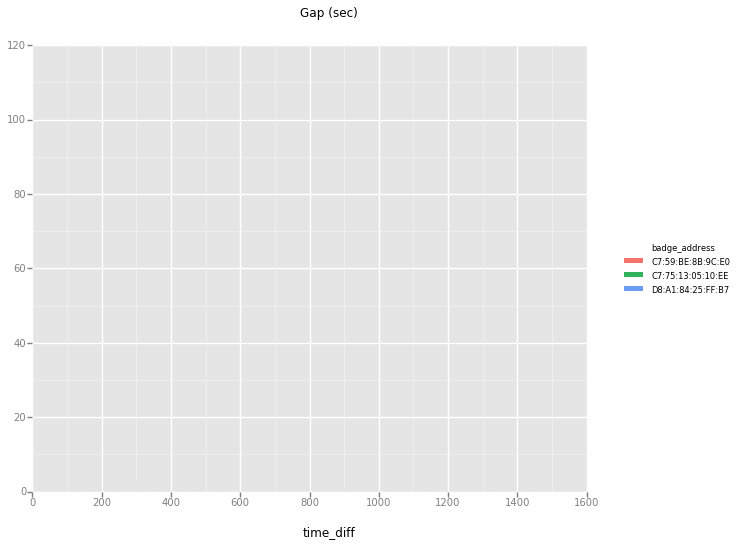

<ggplot: (8772310832417)>

In [20]:
p = ggplot(aes(x='time_diff', fill='badge_address'), data=gaps)
p + geom_histogram(binwidth=1)
p + geom_density(alpha=0.25) 
p + ggtitle("Gap (sec)")